In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Photo_Math_Project

/content/drive/MyDrive/Photo_Math_Project


In [ ]:
import inkml2img as i2i
import os
import numpy as np
import matplotlib.pyplot as plt
import classificator as cl
import torch
from torchvision import transforms
import torchvision
from torch.utils.data import DataLoader

In [ ]:
img = i2i.inkml2img("./Demo_inkml/formulaire005-equation028.inkml", padding = 5, thickness = 3)
img.save("./Temp_imgs/output.png")

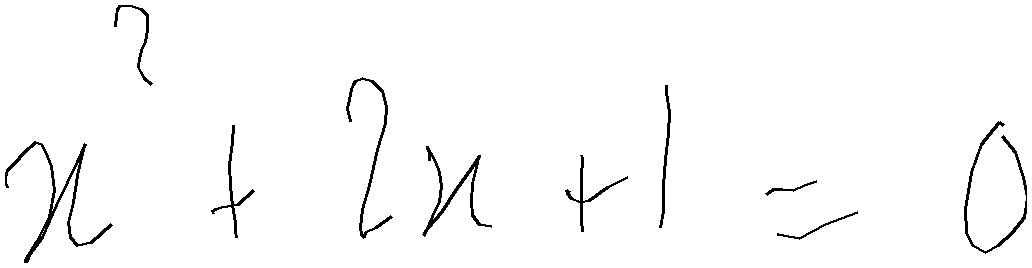

In [ ]:
img

### Load the model

In [ ]:
def make_dataset(paths: list, out_w: int, out_h: int):
    np_dataset = np.zeros((len(paths), out_w, out_h))
    for i, path in enumerate(paths):
        img = i2i.inkml2img(path, out_w, out_h)
        np_dataset[i] = np.array(img)

In [ ]:
classes = ['!', '(', ')', '+', ',', '-', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '=', 'A', 'C', 'Delta', 'G', 'H', 'M', 'N', 'R', 'S', 'T', 'X', '[', ']', 'alpha', 'b', 'beta', 'cos', 'd', 'div', 'e', 'exists', 'f', 'forall', 'forward_slash', 'gamma', 'geq', 'gt', 'i', 'in', 'infty', 'int', 'j', 'k', 'l', 'lambda', 'ldots', 'leq', 'lim', 'log', 'lt', 'mu', 'neq', 'o', 'p', 'phi', 'pi', 'pm', 'prime', 'q', 'rightarrow', 'sigma', 'sin', 'sqrt', 'sum', 'tan', 'theta', 'times', 'u', 'v', 'w', 'y', 'z', '{', '}']

In [ ]:
# Load the model
model = cl.Classificator(len(classes), 1)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load('./Models/main_model.pth',map_location=torch.device(device)))

<All keys matched successfully>

In [ ]:
transform = transforms.Compose([

    transforms.Grayscale(num_output_channels=1),

    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x*2)-1)
])

## Main code

In [ ]:
def predict_symbol(roi, model):
    global transform

    x = transform(roi)

    with torch.no_grad():
        x = x.unsqueeze(0)
        pred = model(x)
    return np.argmax(pred.numpy())

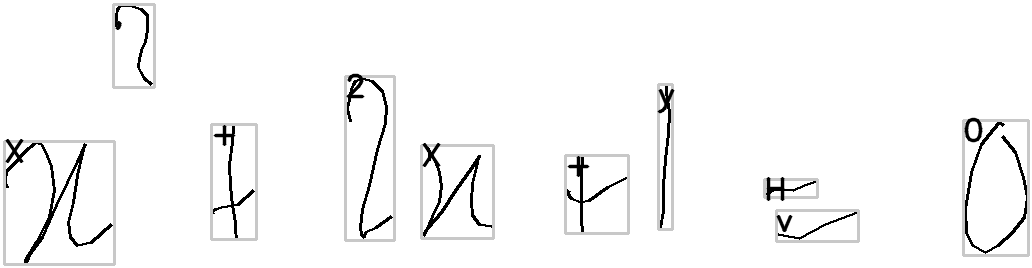

-1

In [ ]:
import cv2
import tensorflow as tf
from PIL import Image
from google.colab.patches import cv2_imshow

# lista svih simbola sa koordinatama
symbol_roi=[]

im = cv2.imread('./Temp_imgs/output.png', 0)
ret, thresh = cv2.threshold(im, 127, 255, 0)
contours, _ = cv2.findContours(thresh,1, 3)

for idx, cnt in enumerate(contours):

    x, y, w, h = cv2.boundingRect(cnt)

    #remove outer most rectangle
    if x == 0 and y == 0 and w == im.shape[1] and h == im.shape[0]:
        continue

    roi = im[y:y + h, x:x + w]

    pred_symb = predict_symbol(Image.fromarray(roi).resize((45,45)), model)
    symbol_roi.append((x,y,w,h,classes[pred_symb]))


good_symbols = []
#find nested boxes
for i, roi in enumerate(symbol_roi):
    x,y,w,h,symb = roi
    is_outer = True

    # check if in another box
    for j, roi2 in enumerate(symbol_roi):
        if i == j:
            continue
        x2,y2,w2,h2,symb2 = roi2

        if x >= x2 and y >= y2 and x + w <= x2 + w2 and y + h <= y2 + h2:
            is_outer = False
            break

    if is_outer:
        good_symbols.append(roi)

# draw rects aroung good symbols
for symbols in good_symbols:
    x,y,w,h,symb = symbols

    #roi = im[y:y + h, x:x + w]
    #Image.fromarray(roi).resize((45,45)).show()

    cv2.rectangle(im, (x, y), (x + w, y + h), (200, 0, 0), 2)
    cv2.putText(im, symb, (x,y+20), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2, cv2.LINE_AA)

cv2_imshow(im)
cv2.waitKey(0)